# Dimensionality Reduction and Embeddings Demo

This notebook demonstrates the various dimensionality reduction methods available in the `neural_analysis.embeddings` module, including:
- PCA (Principal Component Analysis)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- MDS (Multidimensional Scaling)
- Isomap (Isometric Mapping)
- LLE (Locally Linear Embedding)
- Spectral Embedding

All visualizations use the PlotGrid system for consistent, high-quality plots.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_s_curve

from neural_analysis.embeddings import (
    compute_embedding,
    compute_multiple_embeddings,
    pca_explained_variance,
)
from neural_analysis.plotting import PlotGrid, PlotSpec, PlotConfig, GridLayoutConfig

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Reload modules to pick up PlotSpec changes
import importlib
import sys
if 'neural_analysis.plotting.grid_config' in sys.modules:
    importlib.reload(sys.modules['neural_analysis.plotting.grid_config'])
if 'neural_analysis.plotting.renderers' in sys.modules:
    importlib.reload(sys.modules['neural_analysis.plotting.renderers'])
if 'neural_analysis.plotting' in sys.modules:
    importlib.reload(sys.modules['neural_analysis.plotting'])

## 1. Generate Synthetic Neural Data

We'll create high-dimensional data that simulates neural population activity with underlying structure.

In [3]:
# Generate Swiss roll manifold (simulates neural state space)
n_samples = 1000
swiss_roll, swiss_color = make_swiss_roll(n_samples)

print(f"Generated Swiss roll data: {swiss_roll.shape}")
print(f"Simulating {swiss_roll.shape[1]}D neural population responses")
print(f"with {n_samples} time points")

# Generate high-dimensional dataset for variance analysis
# Simulate neural population with 150 neurons
n_neurons = 150
high_dim_data = np.random.randn(n_samples, n_neurons)
# Add some structure: first 10 components have strong signal
for i in range(10):
    signal = np.sin(np.linspace(0, 4*np.pi, n_samples) + i * np.pi/5) * (10 - i)
    high_dim_data[:, i] += signal

print(f"\nGenerated high-dimensional data: {high_dim_data.shape}")
print(f"For comprehensive variance analysis")

Generated Swiss roll data: (1000, 3)
Simulating 3D neural population responses
with 1000 time points

Generated high-dimensional data: (1000, 150)
For comprehensive variance analysis


## 2. Single Method: PCA

Principal Component Analysis is the fastest linear method, ideal for initial exploration.

In [4]:
# Compute PCA embedding
pca_2d = compute_embedding(swiss_roll, method='pca', n_components=2)

print(f"PCA embedding shape: {pca_2d.shape}")
print(f"Reduced from {swiss_roll.shape[1]}D to {pca_2d.shape[1]}D")

PCA embedding shape: (1000, 2)
Reduced from 3D to 2D


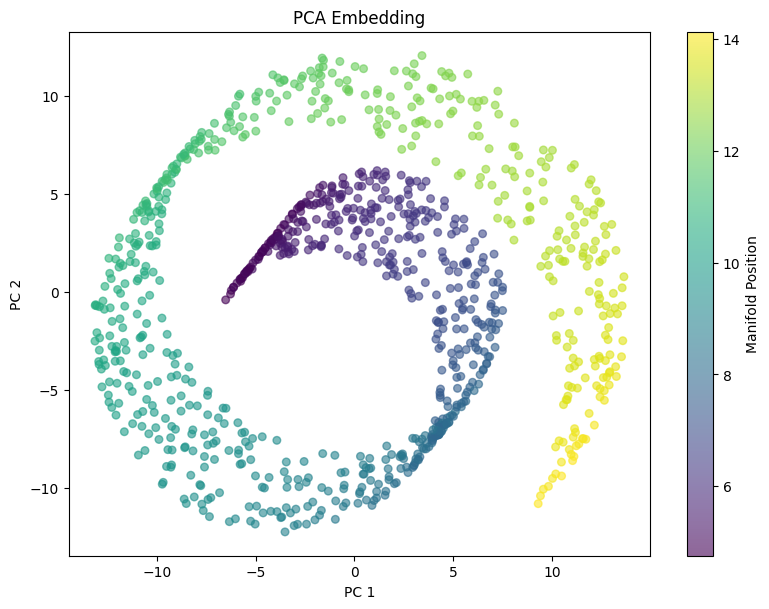

In [5]:
# Visualize PCA using PlotGrid
pca_spec = PlotSpec(
    data=pca_2d,
    plot_type='scatter',
    title='PCA Embedding',
    colors=swiss_color,
    cmap='viridis',  # Explicit colormap
    colorbar=True,
    colorbar_label='Manifold Position',
    alpha=0.6,
    marker_size=30,
)

config = PlotConfig(
    xlabel='PC 1',
    ylabel='PC 2',
    figsize=(8, 6),
)

grid = PlotGrid(plot_specs=[pca_spec], config=config)
fig = grid.plot()
plt.show()

## 3. PCA Variance Analysis

Understand how many components are needed to explain the variance in the data.

In [6]:
# Compute explained variance on high-dimensional data
variance_info = pca_explained_variance(high_dim_data, cumulative=True)

print(f"Components needed for 90% variance: {variance_info['n_components_90']}")
print(f"Components needed for 95% variance: {variance_info['n_components_95']}")
print(f"Components needed for 99% variance: {variance_info['n_components_99']}")
print(f"Total components: {len(variance_info['explained_variance_ratio'])}")

Components needed for 90% variance: 94
Components needed for 95% variance: 118
Components needed for 99% variance: 143
Total components: 150



✓ 118 components capture 95% of the variance
✓ This reduces dimensionality from 150 to 118 (21.3% reduction)


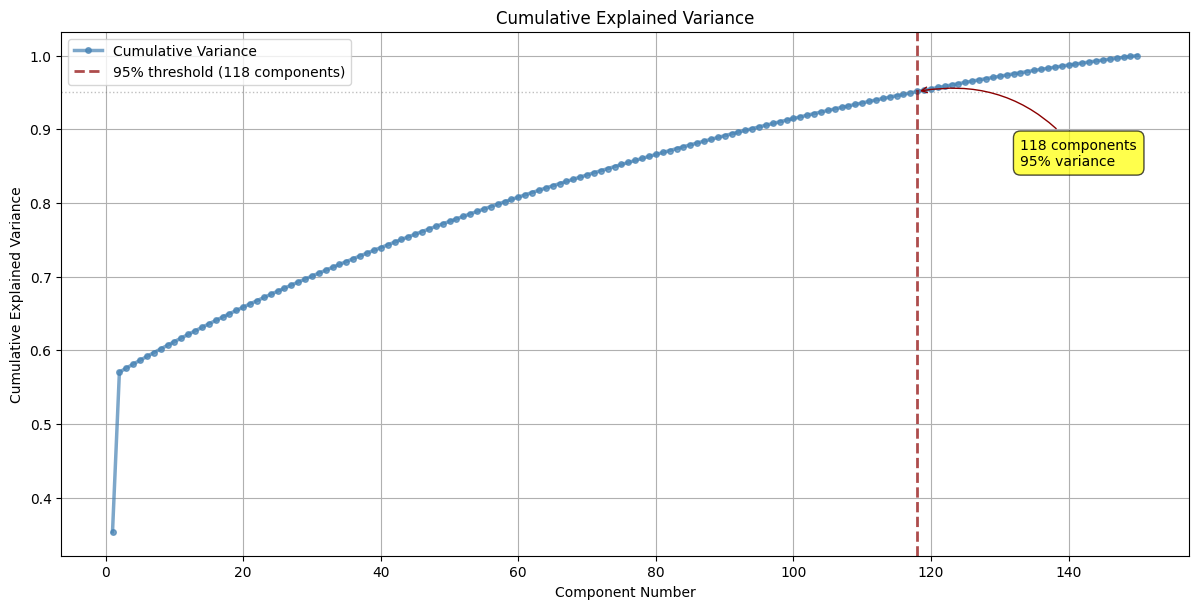

In [7]:
# Create cumulative variance plot using PlotGrid system with integrated reference lines
n_components = len(variance_info['explained_variance_ratio'])
components = np.arange(1, n_components + 1)
n_95 = variance_info['n_components_95']

# Prepare cumulative variance data as 2D array [x, y]
cumulative_data = np.column_stack([components, variance_info['cumulative_variance_ratio']])

# Get cumulative variance at 95% threshold for annotation
cumulative_at_95 = variance_info['cumulative_variance_ratio'][n_95-1]

# Create the cumulative variance line plot with reference lines and annotation
cumulative_spec = PlotSpec(
    data=cumulative_data,
    plot_type='line',
    title='Cumulative Explained Variance',
    color='steelblue',
    line_width=2.5,
    marker='o',
    marker_size=4,
    label='Cumulative Variance',
    # Add vertical line at 95% threshold
    vlines=[
        {
            'x': n_95,
            'color': 'darkred',
            'linestyle': '--',
            'linewidth': 2,
            'label': f'95% threshold ({n_95} components)',
        }
    ],
    # Add horizontal line at 95% value
    hlines=[
        {
            'y': 0.95,
            'color': 'gray',
            'linestyle': ':',
            'linewidth': 1,
            'alpha': 0.5,
        }
    ],
    # Add annotation at the threshold
    annotations=[
        {
            'text': f'{n_95} components\n95% variance',
            'xy': (n_95, cumulative_at_95),
            'xytext': (n_95 + 15, cumulative_at_95 - 0.1),
            'fontsize': 10,
            'bbox': dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            'arrowprops': dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='darkred'),
        }
    ],
)

config = PlotConfig(
    xlabel='Component Number',
    ylabel='Cumulative Explained Variance',
    figsize=(12, 6),
    grid=True,
)

grid = PlotGrid(plot_specs=[cumulative_spec], config=config)
fig = grid.plot()

print(f"\n✓ {n_95} components capture 95% of the variance")
print(f"✓ This reduces dimensionality from {n_components} to {n_95} ({100*(1-n_95/n_components):.1f}% reduction)")

### Test: Cumulative Variance with Plotly Backend

Let's verify the reference lines work with the interactive Plotly backend too.

In [8]:
# Create the same cumulative variance plot with Plotly backend
cumulative_spec_plotly = PlotSpec(
    data=cumulative_data,
    plot_type='line',
    title='Cumulative Explained Variance (Interactive Plotly)',
    color='steelblue',
    line_width=2.5,
    marker='circle',
    marker_size=4,
    label='Cumulative Variance',
    # Add vertical line at 95% threshold
    vlines=[
        {
            'x': n_95,
            'color': 'darkred',
            'linestyle': '--',
            'linewidth': 2,
            'label': f'95% threshold ({n_95} components)',
        }
    ],
    # Add horizontal line at 95% value
    hlines=[
        {
            'y': 0.95,
            'color': 'gray',
            'linestyle': ':',
            'linewidth': 1,
            'alpha': 0.5,
        }
    ],
    # Add annotation at the threshold
    annotations=[
        {
            'text': f'{n_95} components<br>95% variance',
            'xy': (n_95, cumulative_at_95),
            'xytext': (n_95 + 15, cumulative_at_95 - 0.1),
            'fontsize': 10,
            'bbox': dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7),
            'arrowprops': dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='darkred'),
        }
    ],
)

config_plotly = PlotConfig(
    xlabel='Component Number',
    ylabel='Cumulative Explained Variance',
    figsize=(12, 6),
    grid=True,
)

grid_plotly = PlotGrid(plot_specs=[cumulative_spec_plotly], config=config_plotly, backend='plotly')
fig_plotly = grid_plotly.plot()
fig_plotly.show()

print(f"\n✓ Plotly version with reference lines working!")
print(f"✓ Hover over the plot to see interactive features")


✓ Plotly version with reference lines working!
✓ Hover over the plot to see interactive features


## 4. Compare Multiple Methods

Compare different dimensionality reduction methods side-by-side.

In [9]:
# Compute multiple embeddings
methods = ['pca', 'tsne', 'mds', 'isomap']
embeddings = compute_multiple_embeddings(
    swiss_roll, 
    methods=methods, 
    n_components=2,
    random_state=42
)

print("Computed embeddings for:", list(embeddings.keys()))

Computed embeddings for: ['pca', 'tsne', 'mds', 'isomap']


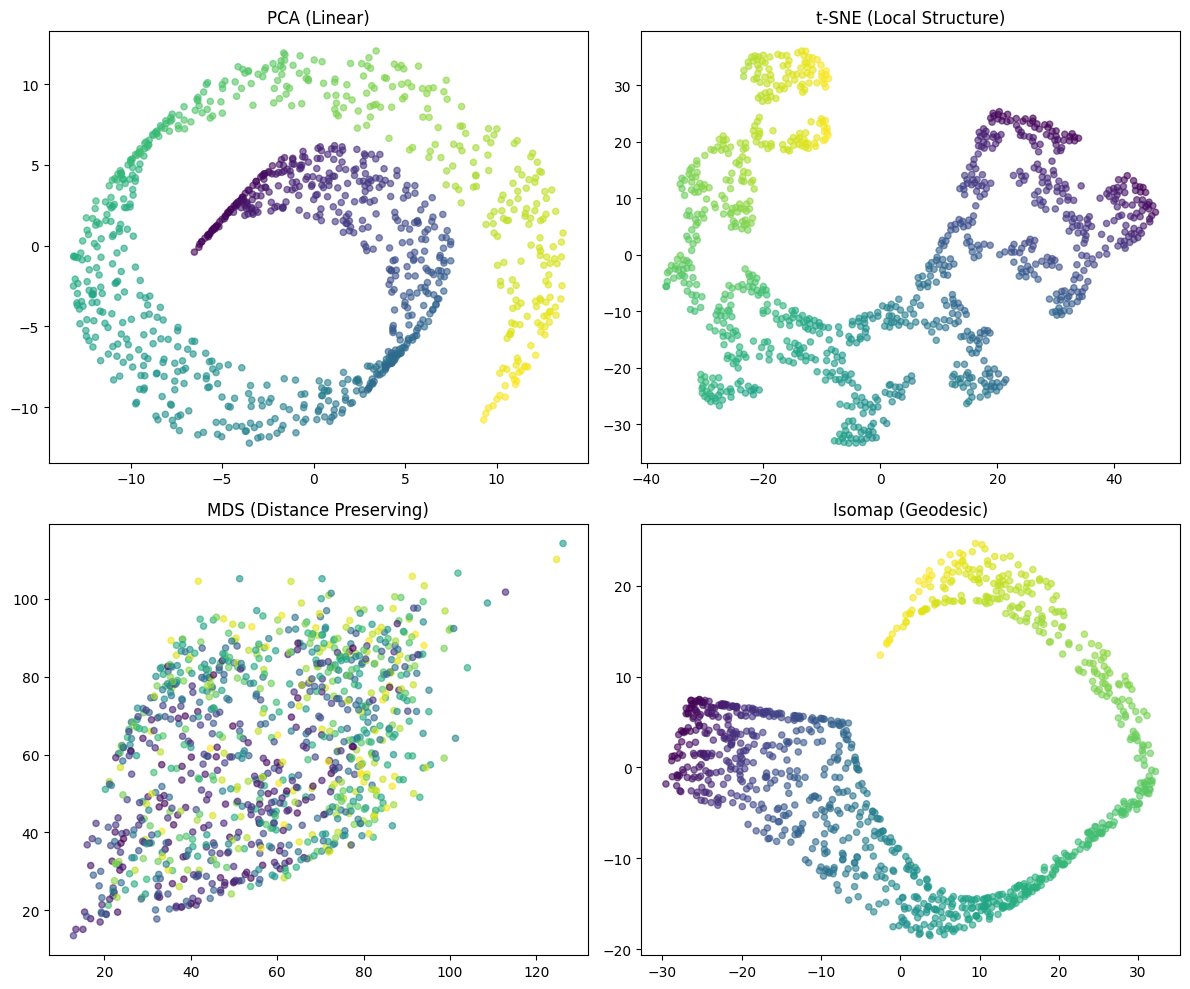

In [10]:
# Create grid visualization comparing all methods
specs = []
titles = {
    'pca': 'PCA (Linear)',
    'tsne': 't-SNE (Local Structure)',
    'mds': 'MDS (Distance Preserving)',
    'isomap': 'Isomap (Geodesic)',
}

for idx, (method, embedding) in enumerate(embeddings.items()):
    specs.append(
        PlotSpec(
            data=embedding,
            plot_type='scatter',
            title=titles[method],
            subplot_position=idx,
            colors=swiss_color,
            colorbar=False,  # Disable for subplots
            alpha=0.6,
            marker_size=20,
        )
    )

config = PlotConfig(
    figsize=(12, 10),
)

layout = GridLayoutConfig(rows=2, cols=2, subplot_titles=[titles[m] for m in methods])
grid = PlotGrid(plot_specs=specs, config=config, layout=layout)
fig = grid.plot()
plt.tight_layout()
plt.show()

## 5. Non-linear Methods: LLE and Spectral

These methods excel at different types of manifold structure.

In [11]:
# Compute LLE and Spectral embeddings
lle_2d = compute_embedding(swiss_roll, method='lle', n_components=2, n_neighbors=12)
spectral_2d = compute_embedding(swiss_roll, method='spectral', n_components=2, n_neighbors=10)

print(f"LLE embedding shape: {lle_2d.shape}")
print(f"Spectral embedding shape: {spectral_2d.shape}")

LLE embedding shape: (1000, 2)
Spectral embedding shape: (1000, 2)


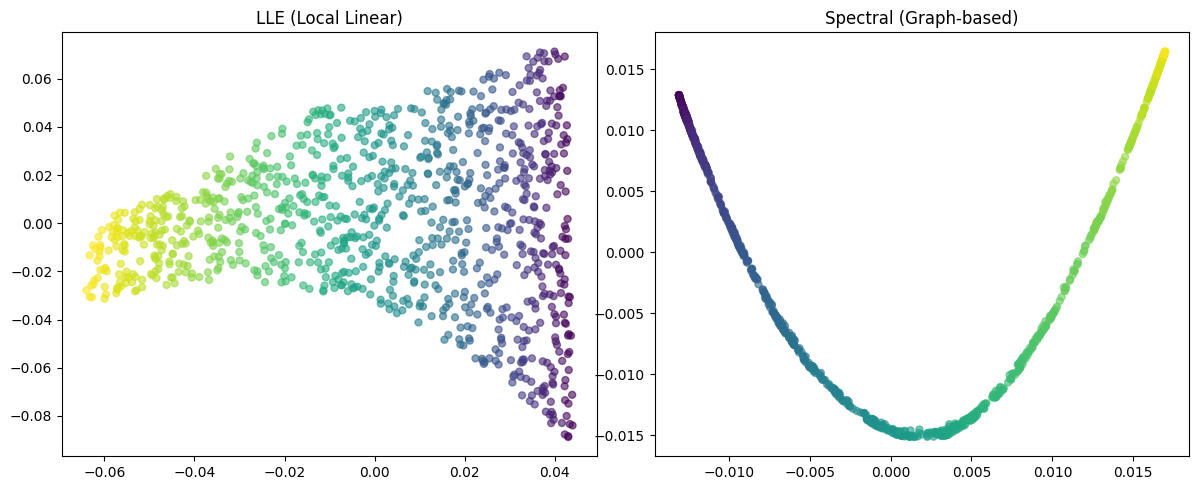

In [12]:
# Visualize LLE and Spectral
specs = [
    PlotSpec(
        data=lle_2d,
        plot_type='scatter',
        title='LLE (Local Linear)',
        subplot_position=0,
        colors=swiss_color,
        alpha=0.6,
        marker_size=25,
    ),
    PlotSpec(
        data=spectral_2d,
        plot_type='scatter',
        title='Spectral (Graph-based)',
        subplot_position=1,
        colors=swiss_color,
        alpha=0.6,
        marker_size=25,
    ),
]

config = PlotConfig(figsize=(12, 5))
layout = GridLayoutConfig(rows=1, cols=2)
grid = PlotGrid(plot_specs=specs, config=config, layout=layout)
fig = grid.plot()
plt.show()

## 6. 3D Embeddings

Sometimes 3D embeddings preserve more structure than 2D.

In [13]:
# Compute 3D embeddings
pca_3d = compute_embedding(swiss_roll, method='pca', n_components=3)
isomap_3d = compute_embedding(swiss_roll, method='isomap', n_components=3, n_neighbors=10)

print(f"PCA 3D embedding shape: {pca_3d.shape}")
print(f"Isomap 3D embedding shape: {isomap_3d.shape}")

PCA 3D embedding shape: (1000, 3)
Isomap 3D embedding shape: (1000, 3)


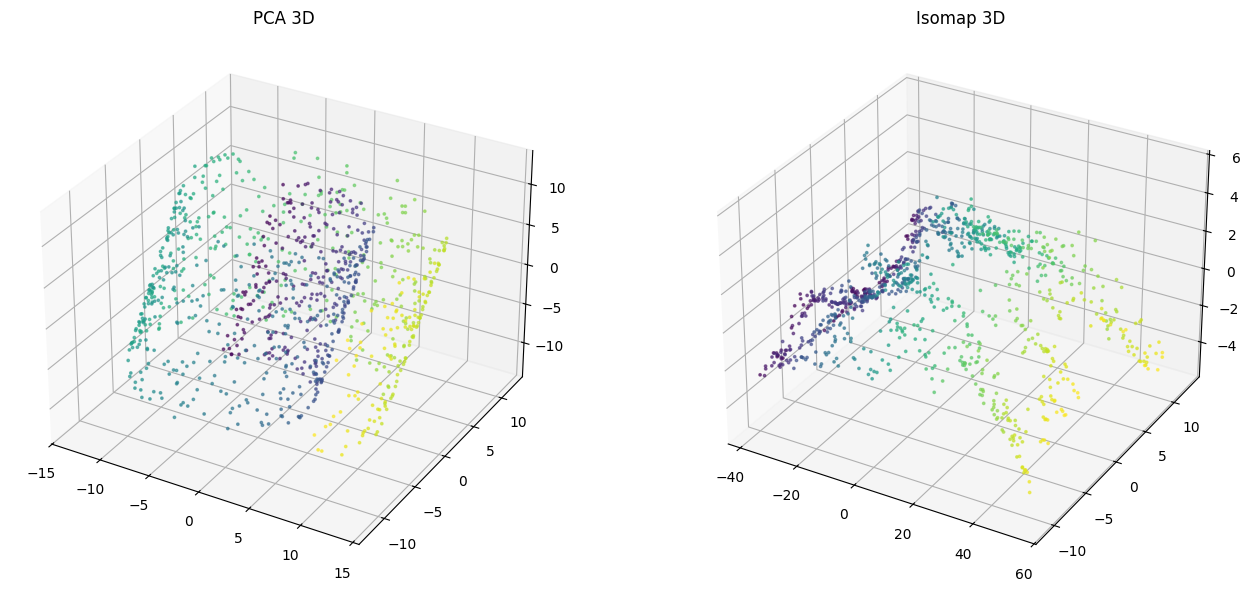

In [14]:
# Visualize 3D embeddings
specs = [
    PlotSpec(
        data=pca_3d,
        plot_type='scatter3d',
        title='PCA 3D',
        subplot_position=0,
        colors=swiss_color,
        alpha=0.6,
        marker_size=3,
    ),
    PlotSpec(
        data=isomap_3d,
        plot_type='scatter3d',
        title='Isomap 3D',
        subplot_position=1,
        colors=swiss_color,
        alpha=0.6,
        marker_size=3,
    ),
]

config = PlotConfig(figsize=(14, 6))
layout = GridLayoutConfig(rows=1, cols=2)
grid = PlotGrid(plot_specs=specs, config=config, layout=layout)
fig = grid.plot()
plt.show()

## 7. Method Selection Guide

Different methods are suited for different scenarios:

- **PCA**: Use for linear relationships, quick exploratory analysis, or when you need to explain variance. Fast and deterministic.

- **t-SNE**: Excellent for visualizing clusters and local structure. Can distort global distances. Slower than UMAP.

- **MDS**: Preserves pairwise distances well. Good when you have a distance matrix. Can be slow for large datasets.

- **Isomap**: Good for data on a non-linear manifold. Uses geodesic distances. Sensitive to neighborhood size.

- **LLE**: Preserves local linear relationships. Fast but can be sensitive to noise.

- **Spectral**: Based on graph Laplacian. Good for data with clear cluster structure.

### For Neural Data:
- Population activity analysis: PCA → t-SNE (in order of speed)
- Trajectory analysis: PCA or Isomap (preserve continuity)
- Cluster identification: Spectral or t-SNE
- Distance matrix: MDS or Isomap with `metric='precomputed'`

## 8. Real Example: S-Curve Manifold

Let's test on a different manifold to see how methods handle different structures.

In [15]:
# Generate S-curve manifold
s_curve, s_color = make_s_curve(n_samples=1000, noise=0.1, random_state=42)

# Compare methods on S-curve
s_embeddings = compute_multiple_embeddings(
    s_curve,
    methods=['pca', 'isomap', 'lle'],
    n_components=2,
    n_neighbors=12,
    random_state=42
)

print("S-curve data shape:", s_curve.shape)

S-curve data shape: (1000, 3)


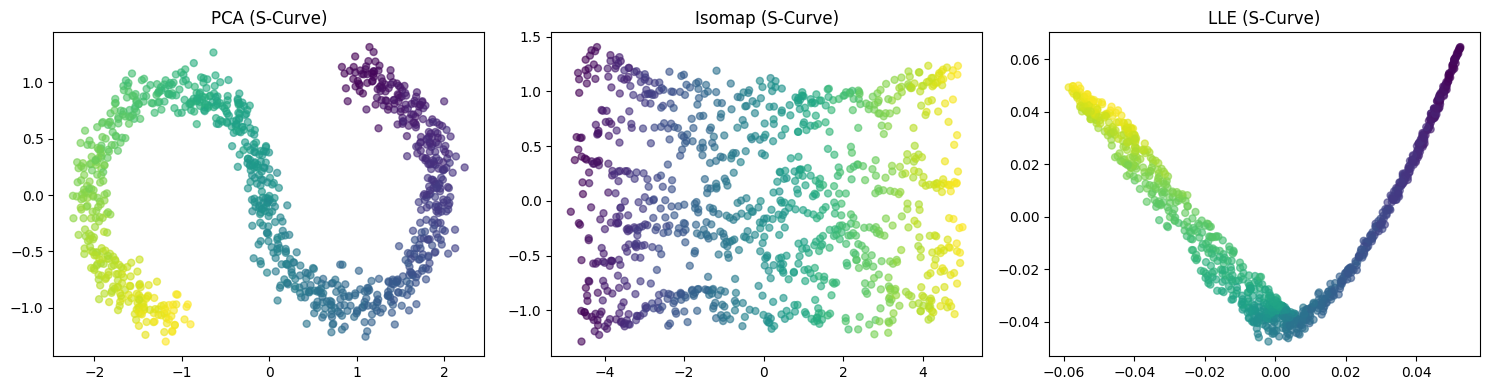


Notice: Isomap and LLE better preserve the intrinsic 1D structure of the S-curve


In [16]:
# Visualize S-curve embeddings
specs = []
titles = {'pca': 'PCA', 'isomap': 'Isomap', 'lle': 'LLE'}

for idx, (method, embedding) in enumerate(s_embeddings.items()):
    specs.append(
        PlotSpec(
            data=embedding,
            plot_type='scatter',
            title=f'{titles[method]} (S-Curve)',
            subplot_position=idx,
            colors=s_color,
            alpha=0.6,
            marker_size=25,
        )
    )

config = PlotConfig(figsize=(15, 4))
layout = GridLayoutConfig(rows=1, cols=3)
grid = PlotGrid(plot_specs=specs, config=config, layout=layout)
fig = grid.plot()
plt.tight_layout()
plt.show()

print("\nNotice: Isomap and LLE better preserve the intrinsic 1D structure of the S-curve")

## Summary

This notebook demonstrated:
1. ✅ Computing single embeddings with `compute_embedding()`
2. ✅ Batch comparison with `compute_multiple_embeddings()`
3. ✅ Variance analysis with `pca_explained_variance()`
4. ✅ Visualization using PlotGrid system
5. ✅ 2D and 3D embeddings
6. ✅ Comparison across different manifold types

All methods are accessed through a unified API and visualized with the consistent PlotGrid interface.